In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

## 1. Encoding Function

In [2]:
def modify_selected_channels(pixel_rgb, message_bits, bits_per_channel, channels_to_encode):
    """Modify selected color channels with message bits"""
    expected_length = len(channels_to_encode) * bits_per_channel
    message_bits = message_bits.ljust(expected_length, '0')
    
    modified_pixel = list(pixel_rgb)
    bit_idx = 0
    
    for channel in channels_to_encode:
        bits = message_bits[bit_idx:bit_idx + bits_per_channel]
        bit_idx += bits_per_channel
        channel_idx = 'RGB'.index(channel)
        value = modified_pixel[channel_idx]
        
        # Mask to clear the LSBs
        mask = 0xFF ^ ((1 << bits_per_channel) - 1)
        cleared = value & mask
        
        # Insert new bits
        modified_pixel[channel_idx] = cleared | int(bits, 2)
    
    return tuple(modified_pixel)


def get_pixel_position(pixel_index, gap, start_row, start_col, rows, cols, horizontal):
    """Get exact pixel position for given index - used by both encode and decode"""
    actual_pixel_offset = pixel_index * (gap + 1)
    
    if horizontal:
        total_offset = start_row * cols + start_col + actual_pixel_offset
        current_row = total_offset // cols
        current_col = total_offset % cols
    else:
        total_offset = start_col * rows + start_row + actual_pixel_offset
        current_col = total_offset // rows
        current_row = total_offset % rows
    
    return current_row, current_col


def encode_message(img_path, out_path, message, start_position=(0, 0), gap=0,
                   channels='RGB', num_bits=1, delimiter_start='#', delimiter_end='#',
                   horizontal=1):
    """
    Parameters:
    - img_path: Path to input image
    - out_path: Path for encoded output image
    - message: Text message to hide
    - start_position: (row, col) starting pixel
    - gap: Skip pixels between encoding (0=consecutive)
    - channels: Color channels to use ('R', 'G', 'B', 'RGB')
    - num_bits: Number of LSB bits to modify (1-8)
    - delimiter_start: Start delimiter (single/multi-char)
    - delimiter_end: End delimiter (single/multi-char)
    - horizontal: 1=row-wise, 0=column-wise traversal
    """
    valid_channels = set('RGB')
    input_channels = set(channels.upper())
    if not input_channels.issubset(valid_channels):
        print("!!! Invalid channel input. Use only 'R', 'G', 'B'.")
        return False

    if not (1 <= num_bits <= 8):
        print("!!! Invalid num_bits. num_bits must be between 1 and 8.")
        return False

    if horizontal not in [0, 1]:
        print("!!! Invalid horizontal value. It should be either 0 or 1.")
        return False

    img = np.array(Image.open(img_path))
    rows, cols, _ = img.shape
    channels = channels.upper()

    r_start, c_start = start_position
    if r_start >= rows or c_start >= cols:
        print(f"!!! Invalid start_position. The start position {start_position} exceeds image dimensions ({rows}, {cols}).")
        return False

    binary_message = ''.join(format(ord(c), '08b') for c in message)

    if delimiter_start:
        binary_start = ''.join(format(ord(c), '08b') for c in delimiter_start)
        binary_message = binary_start + binary_message

    if delimiter_end:
        binary_end = ''.join(format(ord(c), '08b') for c in delimiter_end)
        binary_message += binary_end

    bits_per_pixel = len(channels) * num_bits
    
    if horizontal:
        total_pixels = (cols - c_start) + (rows - r_start - 1) * cols
    else:
        total_pixels = (rows - r_start) + (cols - c_start - 1) * rows
    
    available_pixels = total_pixels // (gap + 1)
    available_bits = available_pixels * bits_per_pixel

    padded_message_length = len(binary_message)
    if len(binary_message) % bits_per_pixel != 0:
        padded_message_length = ((len(binary_message) // bits_per_pixel) + 1) * bits_per_pixel

    if padded_message_length > available_bits:
        print(f"!!! Error: Message is too large. Max bits available: {available_bits}, Required: {padded_message_length} (including padding)")
        return False

    if len(binary_message) % bits_per_pixel != 0:
        binary_message = binary_message.ljust(padded_message_length, '0')

    bit_pointer = 0
    pixel_index = 0
    
    while bit_pointer < len(binary_message):
        current_row, current_col = get_pixel_position(pixel_index, gap, r_start, c_start, rows, cols, horizontal)
        
        if current_row >= rows or current_col >= cols:
            break
            
        pixel = img[current_row, current_col]
        message_bits = binary_message[bit_pointer: bit_pointer + bits_per_pixel]
        modified_pixel = modify_selected_channels(pixel, message_bits, num_bits, channels)
        img[current_row, current_col] = modified_pixel
        bit_pointer += bits_per_pixel
        pixel_index += 1

    # Save image
    Image.fromarray(img).save(out_path)
    return True

# Display original and encoded images

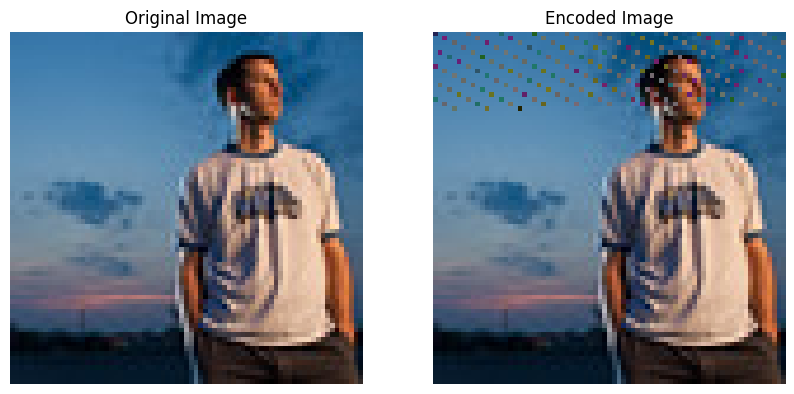

In [3]:
# Display the original and encoded images
def display_images(original_path, encoded_path):
    """Display original and encoded images side by side"""
    original_img = Image.open(original_path)
    encoded_img = Image.open(encoded_path)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(original_img)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Encoded Image")
    plt.imshow(encoded_img)
    plt.axis('off')

    plt.show()
    
message_to_hide = "This is a hidden message without using verification."*10
original_image = 'images/man.jpg'
encoded_image = 'images/simple_encoded.png'

encode_message(
    img_path=original_image,
    out_path=encoded_image,
    message=message_to_hide,
    start_position=(0, 0),
    gap=6,
    channels='RGB',
    num_bits=8,
    delimiter_start='##',
    delimiter_end='##',
    horizontal=1
)



display_images(original_image, encoded_image)


## 2. Decoding Functions


In [4]:
def extract_lsb_bits(pixel_rgb, bits_per_channel, channels_to_decode):
    """Extract LSB bits from pixel channels"""
    extracted_bits = ''
    
    for channel in channels_to_decode:
        channel_idx = 'RGB'.index(channel)
        value = pixel_rgb[channel_idx]
        
        # Extract the LSBs using mask
        mask = (1 << bits_per_channel) - 1
        bits = value & mask
        extracted_bits += format(bits, f'0{bits_per_channel}b')
    
    return extracted_bits


def decode_message(img_path, start_position=(0, 0), gap=0,
                   channels='RGB', num_bits=1, delimiter_start='#', delimiter_end='#',
                   horizontal=1):
    """
    Parameters:
    - img_path: Path to encoded image
    - start_position: (row, col) starting pixel (must match encoding)
    - gap: Skip pixels between decoding (must match encoding)
    - channels: Color channels used (must match encoding)
    - num_bits: Number of LSB bits used (must match encoding)
    - delimiter_start: Start delimiter (single/multi-char, must match encoding)
    - delimiter_end: End delimiter (single/multi-char, must match encoding)
    - horizontal: Traversal direction (must match encoding)
    """
    valid_channels = set('RGB')
    input_channels = set(channels.upper())
    if not input_channels.issubset(valid_channels):
        print("!!! Invalid channel input. Use only 'R', 'G', 'B'.")
        return ""

    if not (1 <= num_bits <= 8):
        print("!!! Invalid num_bits. num_bits must be between 1 and 8.")
        return ""

    if horizontal not in [0, 1]:
        print("!!! Invalid horizontal value. It should be either 0 or 1.")
        return ""

    img = np.array(Image.open(img_path))
    rows, cols, _ = img.shape
    channels = channels.upper()
    
    r_start, c_start = start_position
    if r_start >= rows or c_start >= cols:
        print(f"!!! Invalid start_position. The start position {start_position} exceeds image dimensions ({rows}, {cols}).")
        return ""

    bits_per_pixel = len(channels) * num_bits
    extracted_bits = ''
    pixel_index = 0
    
    while True:
        current_row, current_col = get_pixel_position(pixel_index, gap, r_start, c_start, rows, cols, horizontal)
        
        if current_row >= rows or current_col >= cols:
            break
            
        pixel = img[current_row, current_col]
        pixel_bits = extract_lsb_bits(pixel, num_bits, channels)
        extracted_bits += pixel_bits
        pixel_index += 1
    
    # Convert binary to text
    all_text = ''
    for i in range(0, len(extracted_bits) - 7, 8):
        byte = extracted_bits[i:i+8]
        if len(byte) == 8:
            try:
                char = chr(int(byte, 2))
                all_text += char
            except ValueError:
                continue
    
    message = all_text
    
    # Remove start delimiter if present
    if delimiter_start and message.startswith(delimiter_start):
        message = message[len(delimiter_start):]
    
    # Find and remove end delimiter if present
    if delimiter_end and delimiter_end in message:
        end_pos = message.find(delimiter_end)
        message = message[:end_pos]
    
    return message

# Checking decoding function and encoding function

In [12]:
from input_generator import generate_steganography_input
import os
import tqdm

if not os.path.exists('testing'):
    os.makedirs('testing')

# encode and decode 10000 times
success = 0
total = 10000

for i in tqdm.tqdm(range(total)):
    test_input = generate_steganography_input(75,75)
    encoded_path = f'testing/temp_encoded_{i}.png'
    
    # Encode
    if encode_message('images/man.jpg', encoded_path, test_input['message'], 
                     test_input['start_position'], test_input['gap'], 
                     test_input['channels'], test_input['num_bits'],
                     test_input['delimiter_start'], test_input['delimiter_end'], 
                     test_input['horizontal']):
        
        # Decode 
        decoded = decode_message(encoded_path, test_input['start_position'], 
                               test_input['gap'], test_input['channels'], 
                               test_input['num_bits'], test_input['delimiter_start'], 
                               test_input['delimiter_end'], test_input['horizontal'])
        
        if decoded == test_input['message']:
            success += 1
        else:
            orig_msg = test_input['message']
            max_len = max(len(orig_msg), len(decoded))
            if max_len > 0:
                mismatches = sum(1 for j in range(max_len) if 
                               (j >= len(orig_msg) or j >= len(decoded) or 
                                orig_msg[j] != decoded[j]))
                mismatch_percent = (mismatches / max_len) * 100
            else:
                mismatch_percent = 0
            
            print(f"Test {i} FAILED (Mismatch: {mismatch_percent:.1f}%):")
            print(f"Original: '{orig_msg}'")
            print('=' * 50)
            print(f"Decoded:  '{decoded}'")
            print(f"Parameters: {test_input}")
            print("-" * 50)
    
    # Cleanup
    if os.path.exists(encoded_path):
        os.remove(encoded_path)

print(f"Success Rate: {success}/{total} = {(success/total)*100:.1f}%")

100%|██████████| 10000/10000 [04:16<00:00, 39.05it/s]

Success Rate: 10000/10000 = 100.0%


In [ ]:
# Use fixed parameters for encoding
start_row = 5
start_col = 7
gap = 3
channels = 'RG'
num_bits = 4
delimiter_start = '**'
delimiter_end = '@@'
horizontal = 1

output_image = 'images/decode.png'

encode_message(
    img_path='images/encode.png',
    out_path=output_image,
    message='there is a bomb in the building',
    start_position=(start_row, start_col),
    gap=gap,
    channels=channels,
    num_bits=num_bits,
    delimiter_start=delimiter_start,
    delimiter_end=delimiter_end,
    horizontal=horizontal
)

print(f"Encoded message with parameters:")
print(f"start_position=({start_row}, {start_col}), gap={gap}, channels='{channels}', num_bits={num_bits},")
print(f"delimiter_start='{delimiter_start}', delimiter_end='{delimiter_end}', horizontal={horizontal}")
print(f"Output image saved as: {output_image}")


Encoded message with parameters:
start_position=(5, 7), gap=3, channels='RG', num_bits=4,
delimiter_start='**', delimiter_end='@@', horizontal=1
Output image saved as: images/decode.png


# Future work

generate positions by random(Random LSB)    
Key based encoding
